# Initialization

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import LongType, DecimalType, IntegerType
from pyspark.sql.functions import col, month, year, isnan, desc, unix_timestamp, to_timestamp, dayofmonth, hour, minute, second
from functools import reduce
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Setting up a theme with Seaborn
sns.set_theme(style="whitegrid")

# Adjusting font scale for better readability
sns.set_context("notebook", font_scale=1.2)

In [3]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("Yellow Taxi EDA") \
    .getOrCreate()


# I ran this notebook successfully using 4 cores and 8GB per node in the jupyter session setup. 
# Make sure you allocate enough memory per core. if you chose 3 cores you should select 6GB in your per Node setting.
# spark = SparkSession.builder \
#     .config("spark.driver.memory", "8g") \
# 	.config("spark.executor.memory", "4g") \
#     .config('spark.executor.instances', 6) \
# 	.appName("Yellow Taxi EDA") \
# 	.getOrCreate()

24/05/06 20:17:48 WARN Utils: Your hostname, Mayanks-MacBook-Pro-4.local resolves to a loopback address: 127.0.0.1; using 192.168.1.139 instead (on interface en0)
24/05/06 20:17:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/06 20:17:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark

# Importing Data

In [5]:
# base_path = '/home/mjain3/uci150/mjain3/yellow_taxi_data/yellow_tripdata_2023-{:02d}.parquet'

paths = ['yellow_taxi_data/yellow_tripdata_2023-01.parquet', 'yellow_taxi_data/yellow_tripdata_2023-02.parquet']

# for mo in range(1, 7):  # This loops from 1 to 12
#     path = base_path.format(mo)  # Formats the month with leading zero if necessary
#     paths.append(path)

In [6]:
paths

['yellow_taxi_data/yellow_tripdata_2023-01.parquet',
 'yellow_taxi_data/yellow_tripdata_2023-02.parquet']

In [7]:
# Function to load and cast a single Parquet file
def load_and_cast(filepath):
    df = spark.read.parquet(filepath)
    df = df.withColumn("VendorID", col("VendorID").cast(IntegerType()))
    return df

# Load, cast, and accumulate all DataFrames
dataframes = [load_and_cast(path) for path in paths]
df = reduce(lambda df1, df2: df1.unionByName(df2), dataframes)

# Show the DataFrame
df.show(1)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2023-01-01 00:32:10|  2023-01-01 00:40:36|            1.0|         0.97|       1.0|                 N|         161|         141|           2|        9.3|  1.0|    0.5|       0.

In [8]:
df.count()

5980721

In [9]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



# EDA 

In [10]:
# Summary statistics for numeric fields
numeric_cols = ['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'total_amount']
df.select(numeric_cols).describe().show()

24/05/06 20:17:59 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+-----------------+------------------+
|summary|   passenger_count|     trip_distance|       fare_amount|       tip_amount|      total_amount|
+-------+------------------+------------------+------------------+-----------------+------------------+
|  count|           5832161|           5980721|           5980721|          5980721|           5980721|
|   mean|1.3578207117396108|3.8574354630484002|18.295598793189132| 3.37616698388113|26.960991094487895|
| stddev|0.8927377984327337| 258.9361158969996|17.657792913093825|3.832283059004118|22.007135702165705|
|    min|               0.0|               0.0|            -900.0|           -96.22|           -757.55|
|    max|               9.0|         335004.33|            2203.1|            482.9|            2208.1|
+-------+------------------+------------------+------------------+-----------------+------------------+



In [11]:
# Dictionary to hold the column names and their corresponding counts of missing values
missing_counts = {}

# Calculate missing values for each column, taking data type into consideration
for col_name in df.columns:
    if df.schema[col_name].dataType == "DoubleType" or df.schema[col_name].dataType == "FloatType":
        missing_count = df.filter((col(col_name).isNull()) | (isnan(col_name))).count()
    else:
        missing_count = df.filter(col(col_name).isNull()).count()
    missing_counts[col_name] = missing_count

# Convert the dictionary to a Pandas DataFrame for displaying as a table
missing_counts_df = pd.DataFrame(list(missing_counts.items()), columns=['Column Name', 'Missing Values'])

# Display the DataFrame as a table
print(missing_counts_df)

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=37255Kb max_used=37255Kb free=93816Kb
 bounds [0x00000001069e0000, 0x0000000108e80000, 0x000000010e9e0000]
 total_blobs=13875 nmethods=12871 adapters=915
 compilation: disabled (not enough contiguous free space left)
              Column Name  Missing Values
0                VendorID               0
1    tpep_pickup_datetime               0
2   tpep_dropoff_datetime               0
3         passenger_count          148560
4           trip_distance               0
5              RatecodeID          148560
6      store_and_fwd_flag          148560
7            PULocationID               0
8            DOLocationID               0
9            payment_type               0
10            fare_amount               0
11                  extra               0
12                mta_tax               0
13             tip_amount               0
14           tolls_amount               0
15  improvement_surcharge               0
16           total_amount              

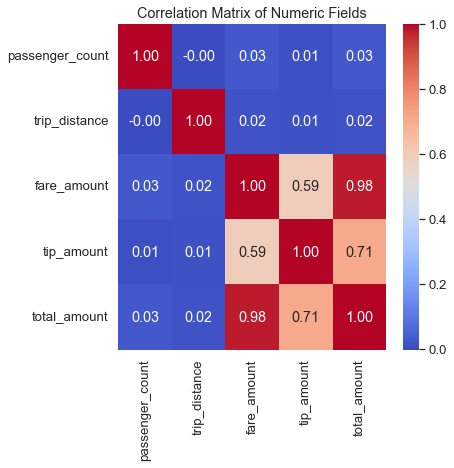

In [12]:
correlation_matrix = pd.DataFrame(index=numeric_cols, columns=numeric_cols)

for col1 in numeric_cols:
    for col2 in numeric_cols:
        corr_value = df.stat.corr(col1, col2)
        correlation_matrix.loc[col1, col2] = corr_value

# Convert entries from object to float for plotting
correlation_matrix = correlation_matrix.astype(float)

# Plotting the correlation matrix
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numeric Fields')
plt.show()

In [13]:
# Most common values for categorical fields
categorical_cols = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type']
for col_name in categorical_cols:
    df.groupBy(col_name).count().orderBy(desc("count")).show()

+--------+-------+
|VendorID|  count|
+--------+-------+
|       2|4364316|
|       1|1615204|
|       6|   1201|
+--------+-------+

+----------+-------+
|RatecodeID|  count|
+----------+-------+
|       1.0|5537989|
|       2.0| 213434|
|      NULL| 148560|
|       5.0|  28166|
|      99.0|  26143|
|       3.0|  17722|
|       4.0|   8694|
|       6.0|     13|
+----------+-------+

+------------------+-------+
|store_and_fwd_flag|  count|
+------------------+-------+
|                 N|5795587|
|              NULL| 148560|
|                 Y|  36574|
+------------------+-------+

+------------+------+
|PULocationID| count|
+------------+------+
|         132|292124|
|         237|283020|
|         161|270755|
|         236|264648|
|         186|213803|
|         162|207241|
|         230|196459|
|         142|193173|
|         138|173693|
|         170|173351|
|         163|168874|
|         239|168559|
|          48|163045|
|         234|162537|
|         141|154956|
|          79

+------------+------+
|DOLocationID| count|
+------------+------+
|         236|279018|
|         237|253194|
|         161|226316|
|         170|174377|
|         230|174285|
|         239|169842|
|         141|168332|
|         142|168258|
|         162|161114|
|          48|150567|
|          68|145302|
|         163|142239|
|         238|141995|
|         234|141706|
|         186|132730|
|         263|132575|
|         229|131815|
|         140|127827|
|          79|127135|
|         107|120543|
+------------+------+
only showing top 20 rows

+------------+-------+
|payment_type|  count|
+------------+-------+
|           1|4721051|
|           2|1009630|
|           0| 148560|
|           4|  65357|
|           3|  36123|
+------------+-------+



In [14]:
# Sampling a fraction of the data for visualization
sampled_df = df.sample(fraction=0.15, withReplacement=False)

In [15]:
def filter_quantile_range(df, col_names, lower_quantile=0.01, upper_quantile=0.99):
    """
    Filter data in the DataFrame based on the specified quantile range for given columns.

    Parameters:
        df (DataFrame): The input DataFrame to filter.
        col_names (list): List of column names to filter on.
        lower_quantile (float): The lower quantile bound (e.g., 0.1 for the 10th percentile).
        upper_quantile (float): The upper quantile bound (e.g., 0.9 for the 90th percentile).

    Returns:
        DataFrame: The filtered DataFrame within the specified quantile range.
    """
    # Initialize an empty list to store the filter conditions
    conditions = []
    
    for column_name in col_names:
        # Get the quantile bounds for the column
        lower_bound, upper_bound = df.approxQuantile(column_name, [lower_quantile, upper_quantile], 0.01)
        
        # Create a condition to filter data within the quantile range for this column
        condition = (col(column_name) >= lower_bound) & (col(column_name) <= upper_bound)
        conditions.append(condition)
    
    # Combine all the conditions using AND (every column must meet its own condition)
    combined_condition = conditions[0]
    for condition in conditions[1:]:
        combined_condition &= condition
    
    # Filter the DataFrame based on the combined condition
    filtered_df = df.filter(combined_condition)
    
    return filtered_df

## 1. Fare amount vs Tip Amount

In [19]:
filtered_df = filter_quantile_range(sampled_df, ["fare_amount", "tip_amount"], lower_quantile=0.05, upper_quantile=0.95)

In [20]:
# Converting Spark DataFrame to Pandas DataFrame
pandas_df = filtered_df.select("fare_amount", "tip_amount").toPandas()

<Figure size 864x432 with 0 Axes>

/Users/mj/conda_env/tf/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


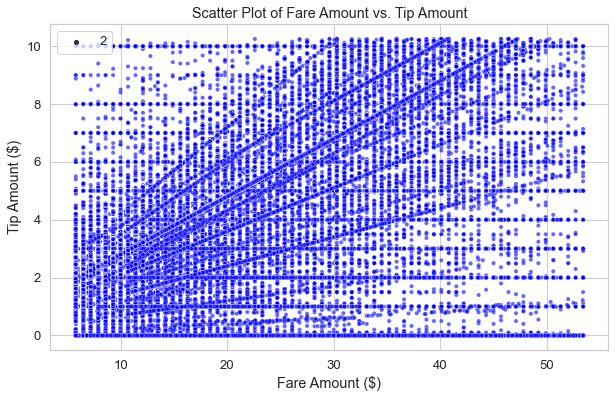

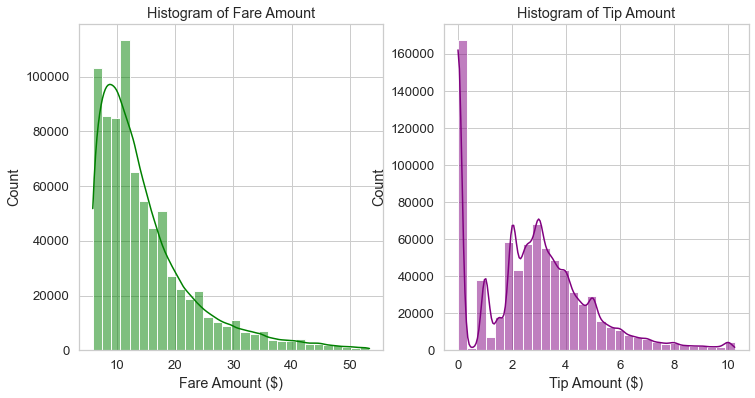

In [21]:
# Boxplot for fare_amount and tip_amount
plt.figure(figsize=(12, 6))

# Scatter plot to observe the relationship between fare amount and tip amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fare_amount', y='tip_amount', data=pandas_df, color='blue', size=2, alpha=0.6)
plt.title('Scatter Plot of Fare Amount vs. Tip Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Tip Amount ($)')
plt.show()

# Histograms to view the distributions of fare amount and tip amount
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(pandas_df['fare_amount'], kde=True, bins=30, color='green')
plt.title('Histogram of Fare Amount')
plt.xlabel('Fare Amount ($)')

plt.subplot(1, 2, 2)
sns.histplot(pandas_df['tip_amount'], kde=True, bins=30, color='purple')
plt.title('Histogram of Tip Amount')
plt.xlabel('Tip Amount ($)')
plt.show()

In [ ]:
# Filter for negative fares and tips, group by payment type
negative_fares_tips = df.filter((col("fare_amount") < 0) | (col("tip_amount") < 0))

In [23]:
negative_fares_tips.groupBy("payment_type").count().show()

+------------+-----+
|payment_type|count|
+------------+-----+
|           0|  130|
|           1|   38|
|           3| 9171|
|           2|11373|
|           4|29110|
+------------+-----+



In [24]:
# Group by RateCodeID for entries with negative fares or tips
negative_fares_tips.groupBy("RateCodeID").count().show()

+----------+-----+
|RateCodeID|count|
+----------+-----+
|      NULL|  130|
|       1.0|44829|
|       4.0|  143|
|       3.0|  572|
|       2.0| 3341|
|       5.0|  807|
+----------+-----+



In [25]:
# Extract year and month, then analyze counts of negative values
negative_fares_tips.withColumn("year", year("tpep_pickup_datetime")) \
    .withColumn("month", month("tpep_pickup_datetime")) \
    .groupBy("year", "month").count().orderBy("year", "month").show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2023|    1|25052|
|2023|    2|24770|
+----+-----+-----+



## 2. Trip Duration vs. Distance

In [76]:
# #Collect duration data
# time_difference_seconds = sampled_df.withColumn("time_difference_seconds",
#                    (col("tpep_dropoff_datetime") - col("tpep_pickup_datetime"))).collect()
                   
# time_difference_seconds_values = [row.time_difference_seconds.total_seconds() for row in time_difference_seconds]

# #Collect trip distance data
# trip_distance = sampled_df.select("trip_distance").collect()
# trip_distance_values = [row[0] for row in trip_distance]

In [61]:
# Calculate the time difference in seconds using unix_timestamp
filtered_df = sampled_df.withColumn(
    "trip_duration_seconds",
    unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))
)

# filter using quantile range function based on time_difference_seconds
filtered_df = filter_quantile_range(filtered_df, ["trip_duration_seconds", "trip_distance"], 0.05, 0.95)

In [62]:
pandas_df = filtered_df.select("trip_duration_seconds", "trip_distance").toPandas()


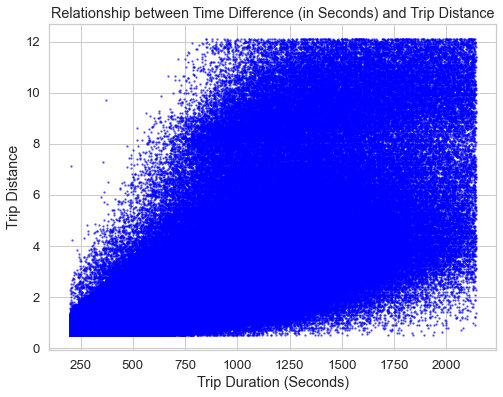

In [63]:
#X/Y plot
plt.figure(figsize=(8, 6))
plt.scatter(x = "trip_duration_seconds", y= "trip_distance", data= pandas_df, color='blue', s=2, alpha=0.5)
plt.title("Relationship between Time Difference (in Seconds) and Trip Distance")
plt.xlabel("Trip Duration (Seconds)")
plt.ylabel("Trip Distance")
plt.grid(True)
plt.show()

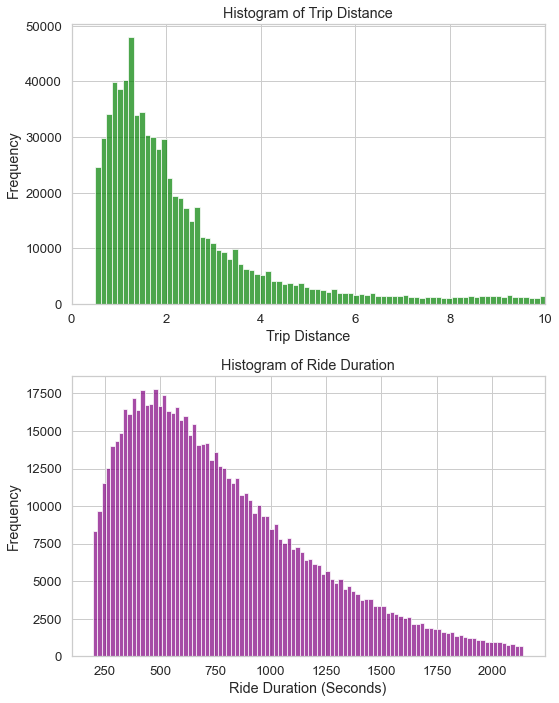

In [67]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

# Histogram for trip distance
axs[0].hist(pandas_df["trip_distance"], bins=100,  color='green', alpha=0.7)
axs[0].set_title('Histogram of Trip Distance')
axs[0].set_xlabel('Trip Distance')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(0, 10)
axs[0].grid(True)

# Histogram for ride duration
axs[1].hist(pandas_df["trip_duration_seconds"], bins=100, color='purple', alpha=0.7)
axs[1].set_title('Histogram of Ride Duration')
axs[1].set_xlabel('Ride Duration (Seconds)')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

plt.tight_layout()
plt.show()

## 3. Trends by hour of day

In [70]:
sampled_df_time = sampled_df.withColumn("tpep_pickup_datetime", to_timestamp("tpep_pickup_datetime"))
sampled_df_time = sampled_df_time.withColumn("year", year("tpep_pickup_datetime")) \
       .withColumn("month", month("tpep_pickup_datetime")) \
       .withColumn("day", dayofmonth("tpep_pickup_datetime")) \
       .withColumn("hour", hour("tpep_pickup_datetime")) \
       .withColumn("minute", minute("tpep_pickup_datetime")) \
       .withColumn("second", second("tpep_pickup_datetime"))

sampled_df_time.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+-----+---+----+------+------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|year|month|day|hour|minute|second|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+-----+---+----+------+------+
|       1| 2023-01-01 00:52:06|  2023-01-01 01:02:18|            2.0|          1.7|  

In [71]:
pandas_time_df = sampled_df_time.select("year","month","day","hour","minute","second","Extra","fare_amount", "trip_distance").toPandas()
pandas_time_df['Amount_per_Distance'] = pandas_time_df["fare_amount"]/pandas_time_df["trip_distance"]
pandas_time_df

,year,month,day,hour,minute,second,Extra,fare_amount,trip_distance,Amount_per_Distance
0,2023,1,1,0,52,6,3.5,11.40,1.70,6.705882
1,2023,1,1,0,58,49,1.0,17.00,2.42,7.024793
2,2023,1,1,0,27,16,1.0,26.10,2.02,12.920792
3,2023,1,1,0,21,29,1.0,5.80,0.61,9.508197
4,2023,1,1,0,20,24,3.5,5.10,0.20,25.500000
...,...,...,...,...,...,...,...,...,...,...
896489,2023,2,28,23,6,34,0.0,15.77,2.85,5.533333
896490,2023,2,28,23,1,50,0.0,16.52,0.00,inf
896491,2023,2,28,23,35,18,0.0,21.99,4.59,4.790850
896492,2023,2,28,23,14,56,0.0,13.42,2.72,4.933824


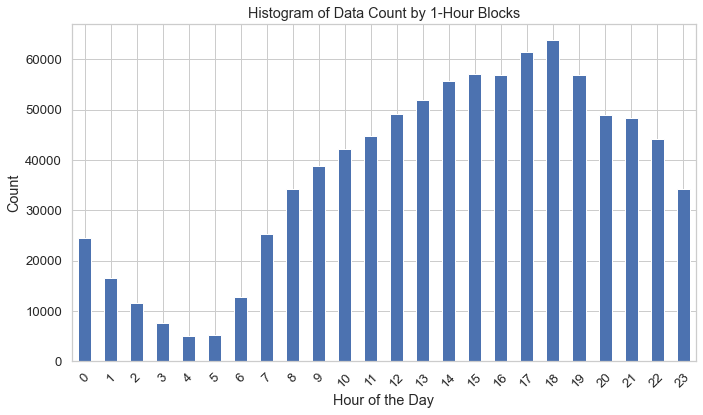

In [72]:
time_block_counts = pandas_time_df.groupby('hour').size()

plt.figure(figsize=(10, 6))
time_block_counts.plot(kind='bar')
plt.title('Histogram of Data Count by 1-Hour Blocks')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

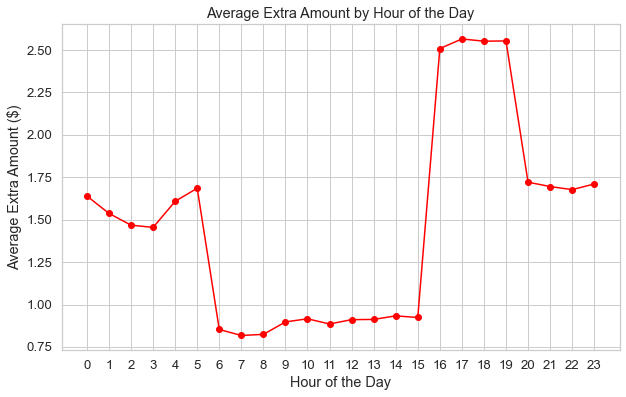

In [73]:
hourly_avg = pandas_time_df.groupby('hour')['Extra'].mean()

plt.figure(figsize=(10, 6))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', color='red')
plt.title('Average Extra Amount by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Extra Amount ($)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

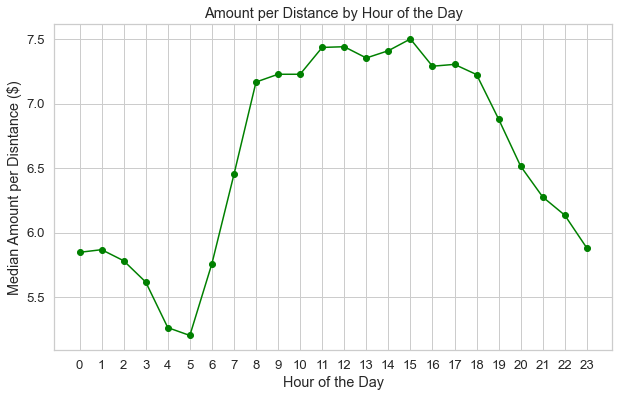

In [74]:
avg = pandas_time_df.groupby('hour')['Amount_per_Distance'].median()

plt.figure(figsize=(10, 6))
plt.plot(avg.index, avg.values, marker='o', color='green')
plt.title('Amount per Distance by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Median Amount per Disntance ($)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()